# Homework 2 - Cedomir Ljubic
## Baysian Regression

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import math

In [9]:
republicans = pd.read_csv(
    "year-sunspots-republicans.csv",sep = "," ,comment = "#")
republicans.head()

,Year,Sunspot_Count,Republican_Count
0,1960,112.3,36
1,1962,37.6,34
2,1964,10.2,32
3,1966,47.0,36
4,1968,105.9,43


# Exercice 1  - Scale

> The numbers in the Year column are large (between 1960 and 2006), especially when raised to
various powers. To avoid numerical instability due to ill-conditioned matrices in most numerical
computing systems, we will scale the data first: specifically, we will scale all “year” inputs by
subtracting 1960 and then dividing by 40

In [10]:
years_scaled = (republicans["Year"] - 1960) / 40

# Exercice 2

We divide Exercice 2 into 3 parts:
- 2.1 Feature engineering (writing the function that generates our design matrixes)
- 2.2 Calculating the posterior parameters
- 2.3 Plotting the actual baysian prediction and the uncertainty around it

### 2.1 - Feature engineering

The following function will give us the design matrix $\Phi_x$ based on the chosen basis functions, where each line corresponds to a training example and each column to a basis function.  

This same function will also give us $\phi(x)$ for our predictions later on.

In [11]:
def X_features(x, basis):
    
    """
    This function allows us to create different design matrices based on the selected
    basis function and the initial feature vector x.
    
    x is a vector of shape (N,)
    """
    
    if basis == 'poly':
        
        X = np.zeros((x.shape[0], 6)) #we have 6 columns instead of 5 because of the bias/intercept term
        for i in range(6):
            X[:, i] = x**i   
        return X
    
    elif basis == 'expo':
        
        mu = np.arange(0, 55, 5)
        X = np.zeros((x.shape[0], len(mu)+1)) 
        X[:, 0] = np.ones(x.shape[0]) #Here again we add the first column to be the bias term
        for i in range(1, len(mu)+1):
            X[:, i] = np.exp(-(40 * x-mu[i-1])**2 / 25)
        return X
    
    elif basis == 'coss':  # Coss stands for cos small because we only have 6 columns
    
        X = np.zeros((x.shape[0], 6)) #we have 6 columns instead of 5 because of the bias/intercept term
        X[:,0] = np.ones(x.shape[0])
    
        for i in range(1, 6):
            X[:, i] = np.cos(x / i)
        return X
    
    elif basis == 'cosb':  # Cosb stands for cos big because we have 26 columns
        X = np.zeros((x.shape[0], 26)) #we have 26 columns instead of 25 because of the bias/intercept term
        X[:, 0] = np.ones(x.shape[0])
    
        for i in range(1, 26):
            X[:, i] = np.cos(x / i)
        features = X    
        return features

### 2.2 - Calculating $m_N$ and $S_N$,( = the mean and covariance matrix of the posterior of w)

When know that when the prior of of w has the following distribution $w|\alpha \sim \mathcal N(0, \alpha^{-1} I_2)$  
Then the posterior of distribution of w given the training data D is:   $w|D \sim \mathcal N(m_N, S_N)$   
With $m_N = \beta S_N \Phi^Ty$  
and $S_N^{-1} = \alpha I + \beta \Phi^T\Phi$

Given the design matrix of the training data \Phi and y_train, the following function returns $m_N$ and $S_N$.

In [12]:
def posterior_params(design, y):
    M = design.shape[1]
    a = 0.01
    S_N_inv = a * np.eye(M) + design.T@design
    S_N = np.linalg.inv(S_N_inv)
    m_N = S_N @ design.T @ y
    return m_N, S_N

### 2.3 - Baysian predictor and posterior standard deviation

Before we plot the baysian predictor, let's first introduce the error function because we will need it later on

Here we chose:  $$ E(w) = \sum\limits_{i = 1}^{N} \frac{1}{2N} (f_{w}(x^{(i)}) - y^{(i)})^2 $$ 

In [13]:
def error_function(y_pred, y):
    N = len(y)
    error = (y_pred - y) **2
    total_error = np.sum(error) / (2*N)
    return total_error

The function we will define next ("predictive_function") will allow us to plot the baysian predictor: $\hat{y}^{\mathcal{D}}(x_{\mathrm{new}}) = \phi(x_{\mathrm{new}})^Tm_N$  

as well as a shaded region that spans $\sigma_N(x_\text{new}) = \sqrt[]{1/\beta + \phi(x_{\mathrm{new}})^TS_N\phi(x_{\mathrm{new}})} $ on either side of the baysian predictor.

Where $\sigma_N(x_\text{new})^2$ is the variance of the baysian predictive distribution $y_\text{new} | x_\text{new}$ 

In [14]:
def predictive_function(x_train, y_train, basis, x_axis):

    """
    This function plots the baysian predictive function for a new y given a new x, the training data,
    alpha and beta.
    
    It also plots the predictive standard deviation around the baysian predictor.
    
    The "x_axis" parameter allows us to decide whether we want Years or Sunspots to be plotted on the x_axis.
    """    
    
    design = X_features(x_train, basis)
    m_N, S_N = posterior_params(design, y_train)
    
    x_new = np.linspace(x_train.min(), x_train.max(), 100) 
    Phi_new = X_features(x_new, basis)
    y_pred =  Phi_new @ m_N
    
    predictive_stdv = np.sqrt(1 + np.diag(Phi_new @ S_N @ Phi_new.T))
    predict_sup = y_pred + predictive_stdv
    predict_inf = y_pred - predictive_stdv
    
    error = round(error_function(design @ m_N, y_train), 2)
    
    fig, ax = plt.subplots(1,figsize=(10, 5))
    
    ax.set_title(f"Baysian predictive function for linear regression with uncertainty and basis = {basis}, train error = {error}"
                    , fontsize = 12)
    ax.set_ylabel("Republicans")
    
    if x_axis == "Years":
    
        ax.set_xlabel("Year")
        ax.scatter(x_train*40 + 1960, republicans["Republican_Count"])
        ax.plot(x_new*40 + 1960, y_pred, color = 'r', label = "Baysian predictor")

        ax.fill_between(x_new*40 + 1960, predict_inf, predict_sup, label='Uncertainty',
                         facecolor='blue', alpha=0.1)
        
    elif x_axis == "Sunspots":
        
        ax.set_xlabel("Sunspots")
        ax.scatter(x_train*20, y_train)
        ax.plot(x_new*20, y_pred, color = 'r', label = "Baysian predictor")

        ax.fill_between(x_new*20, predict_inf, predict_sup, label='Uncertainty',
                         facecolor='blue', alpha=0.1)
    
    ax.legend()
        

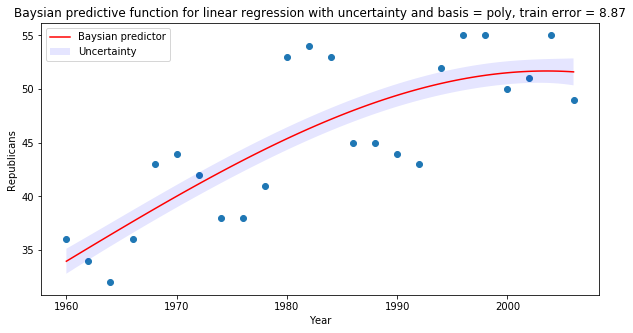

In [15]:
predictive_function(years_scaled, republicans["Republican_Count"], 'poly', "Years")

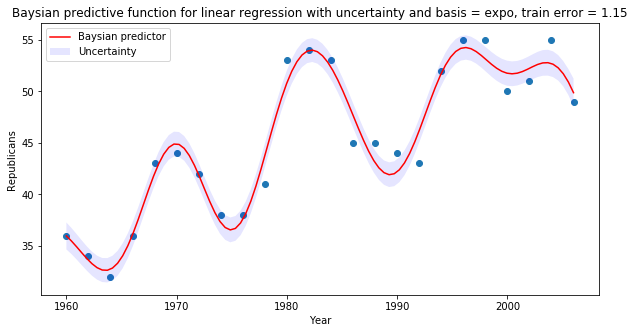

In [16]:
predictive_function(years_scaled, republicans["Republican_Count"], 'expo', "Years")

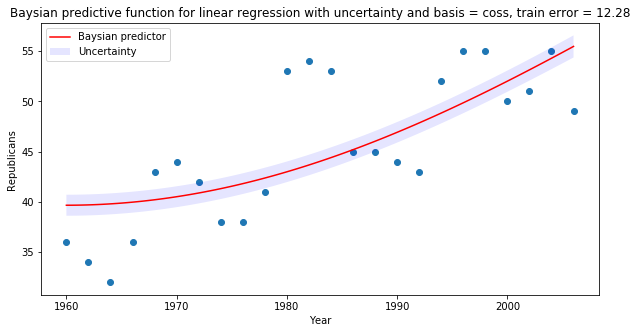

In [17]:
predictive_function(years_scaled, republicans["Republican_Count"], 'coss', "Years")

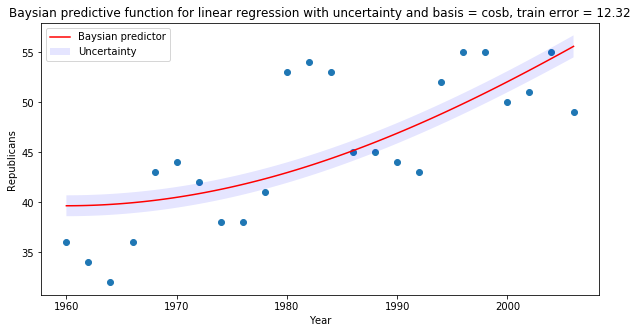

In [18]:
predictive_function(years_scaled, republicans["Republican_Count"], 'cosb', "Years")

## Exercice 3 - Sunspots vs Republicans

Repeat the same exact process as above but for Number of Sunspots (x-axis) v. Number
of Republicans in the Senate (y-axis). Here, to avoid numerical instability with numbers
in the Sunspot Count column, we will also scale the data first by dividing all “sunspot count”
inputs by 20. In addition, only use data from before 1985, and only use basis functions (a),
(c), and (d) – ignore basis (b). You will therefore make 3 total plots. For each plot make
sure to also include the train error

In [24]:
sunspots = republicans["Sunspot_Count"][republicans["Year"]<1985]

sunspots_scaled = sunspots/20

republicans_1985 = republicans["Republican_Count"][republicans["Year"]<1985]

# In the next two lines we sort the sunspots vector by increasing value
# and we keep the indexes_sorted array so that we can also reorder the republicans vector in the same order as the sunspots
sunspots_sorted = np.sort(sunspots_scaled)

indexes_sorted = np.argsort(sunspots).to_numpy()

republicans_sorted = [republicans_1985[idx] for idx in indexes_sorted]
republicans_sorted = np.array(republicans_sorted)

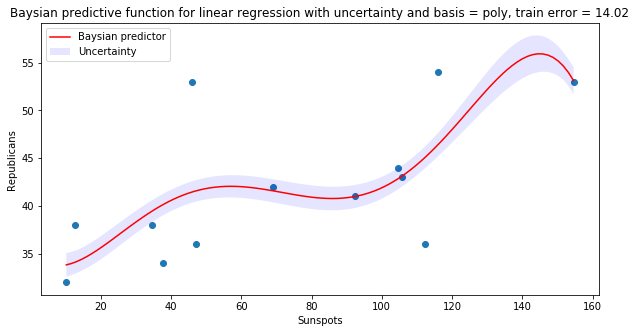

In [25]:
predictive_function(sunspots_sorted, republicans_sorted, 'poly', "Sunspots")

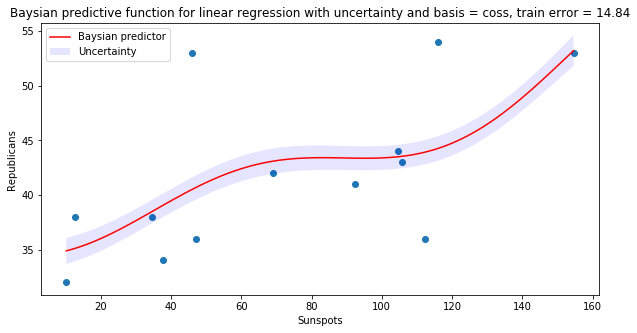

In [26]:
predictive_function(sunspots_sorted, republicans_sorted, 'coss', "Sunspots")

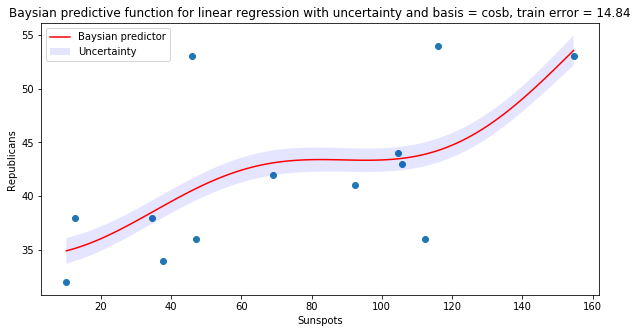

In [27]:
predictive_function(sunspots_sorted, republicans_sorted, 'cosb', "Sunspots")

# 4. Compute the marginal likelihood (or normalizing constant) for the the three bases (a, c, d).

In order to compute the log of the marginal likelihood we will use the formula from slide 40 from class. The formula is long so we will not write it in Latex here.

In [101]:
def marginal_log_likelihood(x_train, y_train, basis, alpha = 0.01, beta = 1):
    
    design = X_features(x_train, basis)
    m_N, S_N = posterior_params(design, y_train)
    
    M = design.shape[1]
    N = design.shape[0]
    
    error_m_N = beta/2 * np.sum( (y_train - design @ m_N)**2 ) + alpha/2 * np.sum(m_N**2)
    
    log_marginal_l = M/2 * np.log(alpha) + N/2 * np.log(beta) - error_m_N + 1/2 * np.log(np.linalg.det(S_N)) - N/2 * np.log(2*math.pi)
    
    return log_marginal_l

In [102]:
basis = ['poly', 'coss', 'cosb']
labels = ['Poly', 'Cos small', 'Cos big']

for base, label in zip(basis, labels):
    
    marginal_log_like = marginal_log_likelihood(sunspots_sorted, republicans_sorted, base, alpha = 0.01, beta = 1)
    print("The log of the marginal likelihood associated to the base {} is {}".format(label, round(marginal_log_like,2)))
    

The log of the marginal likelihood associated to the base Poly is -233.37
The log of the marginal likelihood associated to the base Cos small is -228.11
The log of the marginal likelihood associated to the base Cos big is -220.27


# 5 .Deduce from your last answer, which of the three bases (a, c, d) provided the ”best” fit from a Bayesian perspective?

#### Comparing the three models, we got the maximum evidence $p(\mathcal D|M_i)$, or maximum marginal likelihood from the "Cosinus big" model. Therefore it was the model which was most likely out of the three to generate our data or provided the best "fit".

#### We could now calculate the posterior distribution of our models given our data $p(\mathcal M_i|D) \propto p(\mathcal M_i)p(\mathcal D|M_i) $. If we have preferences for a certain model we can express it through the prior $p(\mathcal M_i)$ and find a different most likely model.

# 6. Discuss on the choice of α and σ.

#### We would find "better" choices for parameters alpha and beta, by using the procedure described in 3.5.2 of PRML, where we maximize the marginal likelihood with respect to alpha and to beta.
#### Otherwise if we had considered alpha and beta unknown we could have also approximated them through a baysian approach described in the slides.